In [1]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv3D, Dense ,Dropout, Flatten, Activation, MaxPooling3D, Input

In [2]:
def CNN_3D_REG(X_train, learning_rate = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(input_a)
    x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = Dropout(0.30)(x)
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = Dropout(0.30)(x)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = Dropout(0.10)(x)
    out = Flatten()(x)
    
    dense = Dense(2000, activation = 'relu')(out)
    dense = Dense(300, activation = 'relu')(dense)
    dense = Dense(150, activation = 'relu')(dense)
    dense = Dense(20, activation = 'relu')(dense)
    dense = Dense(16, activation = 'linear')(dense)
    # final layer with 10 neurons to classify the instances
    output = Dense(1, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(learning_rate = learning_rate)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [25]:
mesh = trimesh.load("dataset/0002_7.15_2328.stl")

Data not utf-8! Trying ISO-8859-1 (confidence 0.73)


In [3]:
def augment(points):
    # jitter points
    points += tf.random.uniform(points.shape, -0.05, 0.05, dtype=tf.float32)
    # shuffle points
    points = tf.random.shuffle(points)
    return points


In [14]:
n_samples = 10000
n_aug_samples = 1
X_train = np.zeros([0,n_samples,3])
y_train = np.zeros(0)
for filename in os.listdir("dataset/"):
    if filename.endswith(".stl"):
        #print(filename[5:9])
        print("appending", filename)
        mesh = trimesh.load("dataset/"+filename)
        points = mesh.sample(n_samples)

        for n in range(n_aug_samples):
            points = augment(points)    
            X_train = np.append(X_train,points[np.newaxis,...],axis=0)
            y_train = np.append(y_train,filename[5:9])
        

    

Data not utf-8! Trying ISO-8859-1 (confidence 0.73)


appending 0006_0.41_154.stl


Data not utf-8! Trying ISO-8859-1 (confidence 0.73)
Data not utf-8! Trying ISO-8859-1 (confidence 0.73)
Data not utf-8! Trying ISO-8859-1 (confidence 0.73)
Data not utf-8! Trying ISO-8859-1 (confidence 0.73)


appending 0010_1.30_555.stl
appending 0007_1.47_743.stl
appending 0005_0.40_176.stl
appending 0002_7.15_2328.stl


Data not utf-8! Trying Windows-1252 (confidence 0.73)
Data not utf-8! Trying ISO-8859-1 (confidence 0.73)


appending 0008_1.52_564.stl
appending 0003_2.64_910.stl


Data not utf-8! Trying ISO-8859-1 (confidence 0.73)
Data not utf-8! Trying ISO-8859-1 (confidence 0.73)
Data not utf-8! Trying ISO-8859-1 (confidence 0.73)


appending 0001_0.42_162.stl
appending 0009_7.15_531.stl
appending 0004_0.40_197.stl


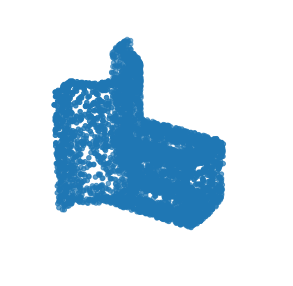

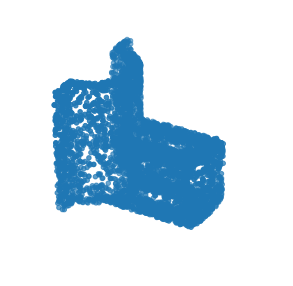

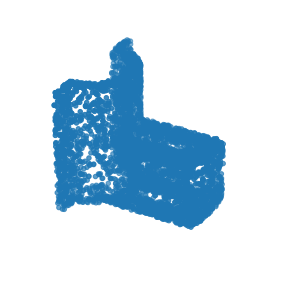

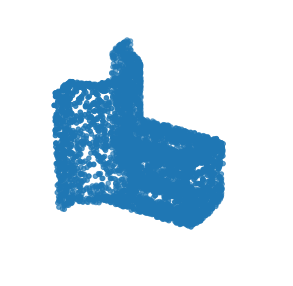

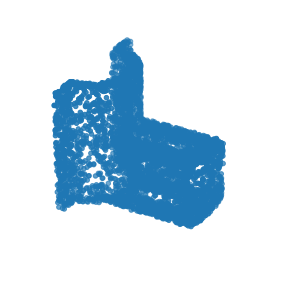

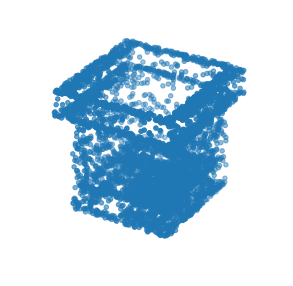

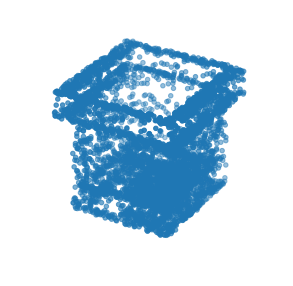

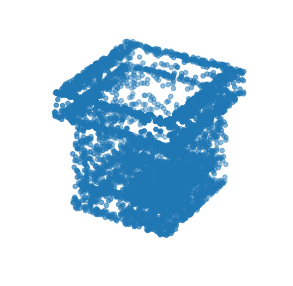

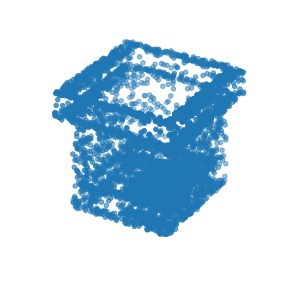

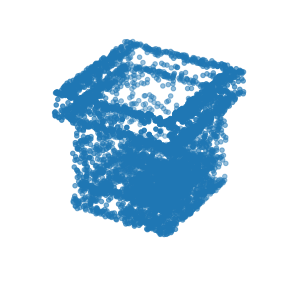

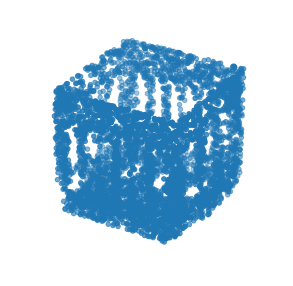

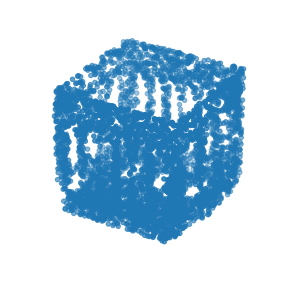

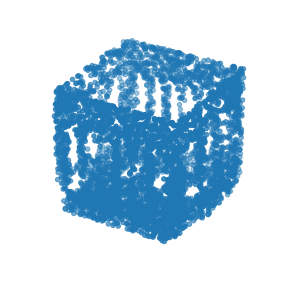

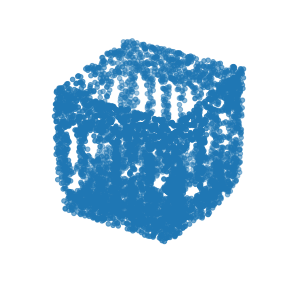

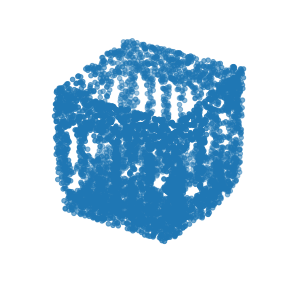

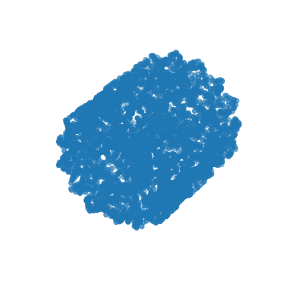

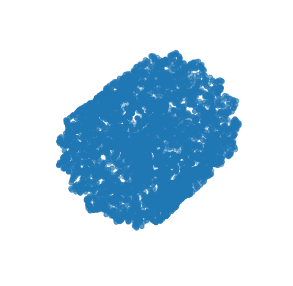

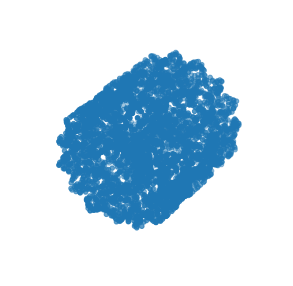

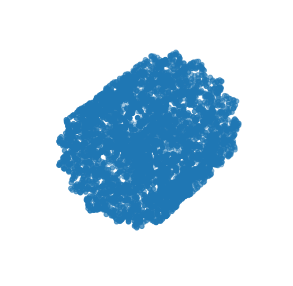

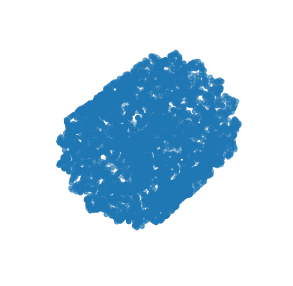

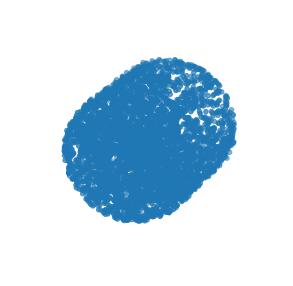

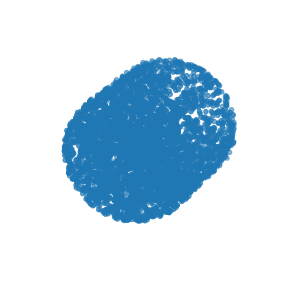

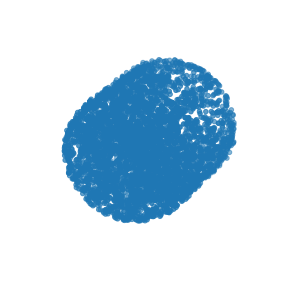

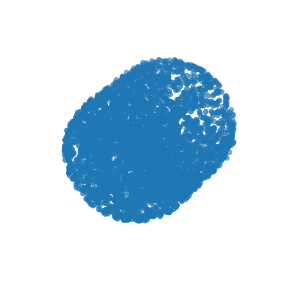

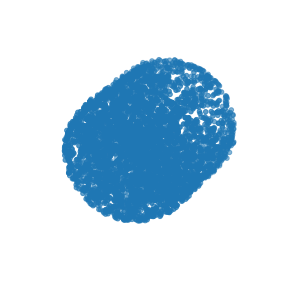

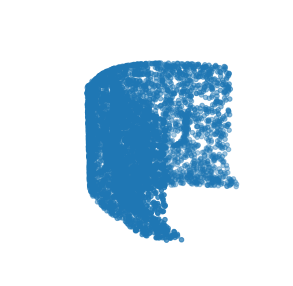

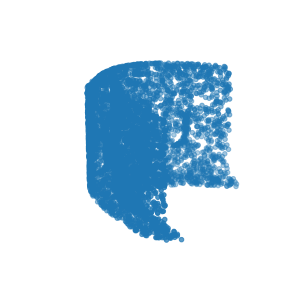

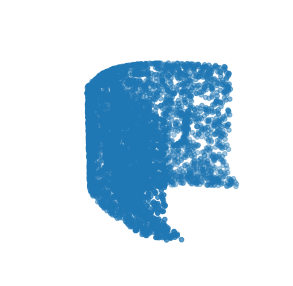

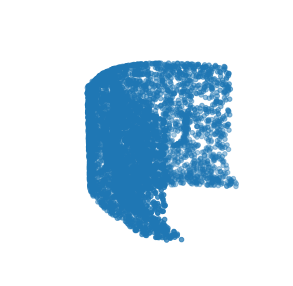

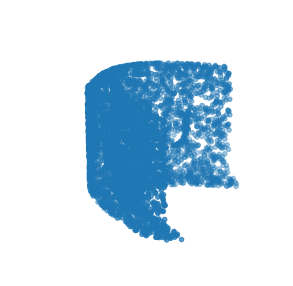

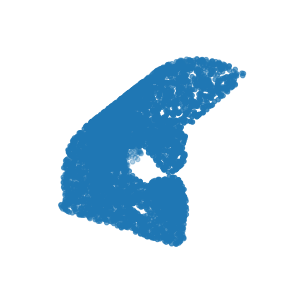

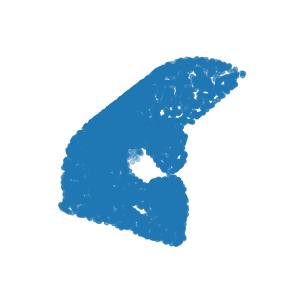

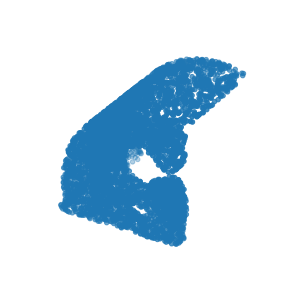

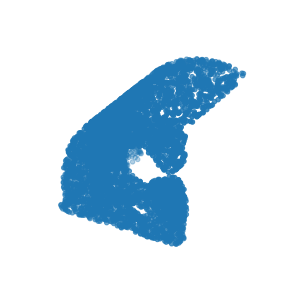

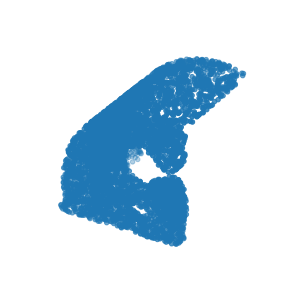

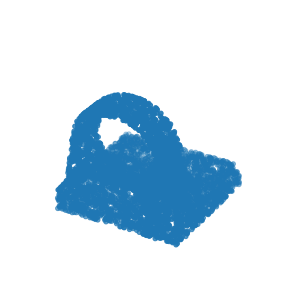

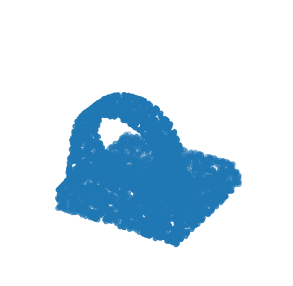

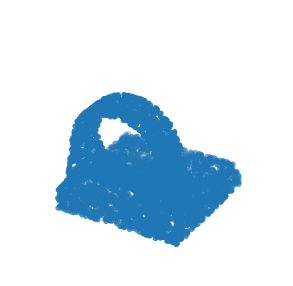

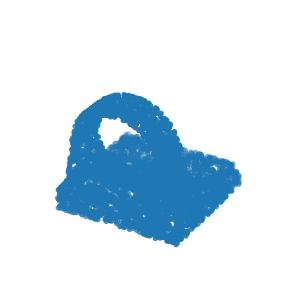

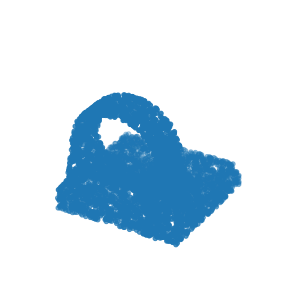

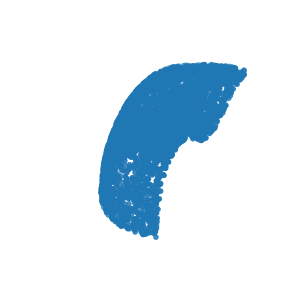

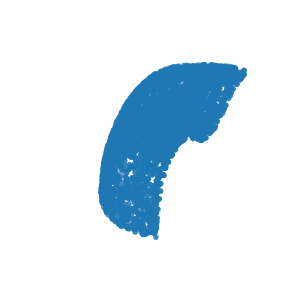

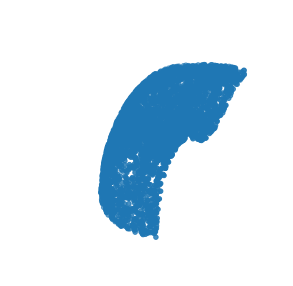

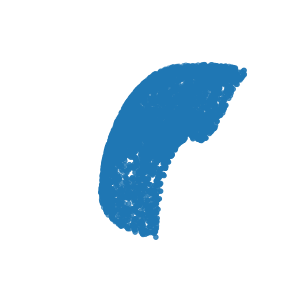

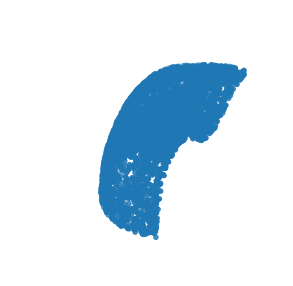

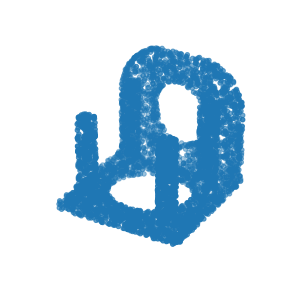

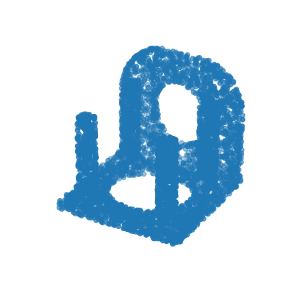

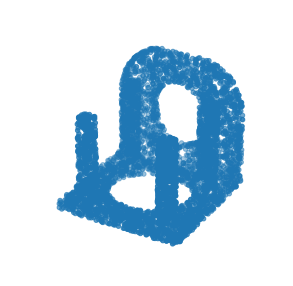

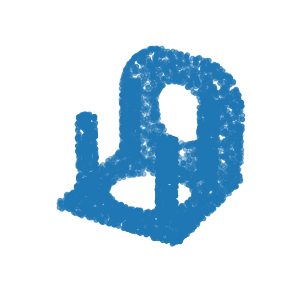

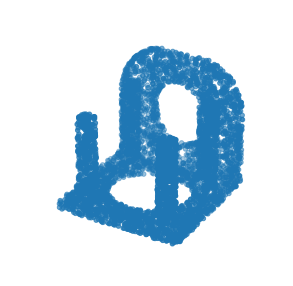

In [85]:
points = mesh.sample(5000)
#points = augment(points)
for points in X_train:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])
    ax.set_axis_off()
    plt.show()

In [15]:
X_train.shape

(10, 10000, 3)

In [6]:
#Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
#model = CNN_3D_REG(X_train,learning_rate= 0.00002)
#print(model.summary())
# model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
model.fit(X_train, y_train, batch_size = 8,validation_split = 0.2, epochs = 10, verbose = 2)
#esults = model.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

NameError: name 'model' is not defined

In [16]:
inputs = keras.Input(shape=(X_train.shape[1:]))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)
dense = Dense(2000, activation = 'relu')(x)
dense = Dense(300, activation = 'relu')(dense)
dense = Dense(150, activation = 'relu')(dense)
dense = Dense(20, activation = 'relu')(dense)
dense = Dense(16, activation = 'relu')(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    
#outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=output, name="pointnet")
#model.summary()

In [7]:
def augment(points):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points

#fuctions to build models 
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

#function to create T-net layers
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [17]:
y_train = np.float64(y_train)
y_train_max = y_train.max()
model.compile(
    loss="MSE",
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    metrics=["accuracy"],
)

model.fit(X_train, y_train/y_train_max, batch_size = 8, epochs = 5, verbose = 2,validation_split=0.2)


Epoch 1/5
1/1 - 39s - loss: 0.6306 - accuracy: 0.0000e+00 - val_loss: 0.4350 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 - 22s - loss: 0.6323 - accuracy: 0.0000e+00 - val_loss: 0.5142 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 - 19s - loss: 0.6357 - accuracy: 0.0000e+00 - val_loss: 0.5478 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 - 22s - loss: 0.6394 - accuracy: 0.0000e+00 - val_loss: 0.5290 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 - 43s - loss: 0.6269 - accuracy: 0.0000e+00 - val_loss: 0.5011 - val_accuracy: 0.0000e+00


In [18]:
y_train_max = y_train.max()
preds = model.predict(X_train)#*y_train_max

In [24]:
preds.flatten()

array([1.341144 , 1.7830557, 1.3602438, 0.6362875, 2.7891288, 2.3028457,
       5.787232 , 0.8922711, 3.8804996, 7.15     ], dtype=float32)

In [25]:
y_train

array([0.41, 1.3 , 1.47, 0.4 , 7.15, 1.52, 2.64, 0.42, 7.15, 0.4 ],
      dtype=float32)

In [20]:
y_train

array([0.41, 1.3 , 1.47, 0.4 , 7.15, 1.52, 2.64, 0.42, 7.15, 0.4 ],
      dtype=float32)